# VGG from Scratch in PyTorch

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms

from collections import OrderedDict
import os
import multiprocessing

In [3]:
!pip install -r requirements.txt

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
# Print the type of the GPU used
print("GPU Model: ", torch.cuda.get_device_name(0))

# Print CPU Information
print("CPU ", end='')
os.system("cat /proc/cpuinfo | grep 'model name' | uniq");
print("CPU Count: ", multiprocessing.cpu_count())

GPU Model:  Tesla T4
CPU model name	: Intel(R) Xeon(R) Platinum 8259CL CPU @ 2.50GHz
CPU Count:  4


In [6]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=14930MB, multi_processor_count=40)

In [7]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Data Loading

In [8]:
from src.data import get_data_loaders
data_loaders = get_data_loaders(data_dir="./data", batch_size=4)

Files already downloaded and verified
Files already downloaded and verified


## PyTorch Implementation of VGG16 

[PyTorch Repository Source Code](https://github.com/pytorch/vision/blob/main/torchvision/models/vgg.py)

In [9]:
from torchvision.models import vgg16_bn

In [10]:
vgg16_pt = vgg16_bn(weights='IMAGENET1K_V1')

In [11]:
vgg16_pt

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

### Visualizing the Netowrk Using Netron

In [16]:
X, y = next(iter(data_loaders["train"]))
scripted = torch.jit.trace(vgg16_pt, X)

/opt/conda/lib/python3.10/site-packages/torch/jit/_trace.py:1084: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 4000 / 4000 (100.0%)
Greatest absolute difference: 3.621911406517029 at index (0, 503) (up to 1e-05 allowed)
Greatest relative difference: 1379.0700100499666 at index (2, 371) (up to 1e-05 allowed)
  _check_trace(


In [11]:
torch.jit.save(scripted, "visualization/vgg16_pytorch_implementation.pt")

### Model Complexity

In [12]:
# Model complexity - calculating the total number of parameters
trainable_params = sum(p.numel() for p in vgg16_pt.parameters() if p.requires_grad)
trainable_params

138365992

## Fady's VGG 16 Architecture Implementation

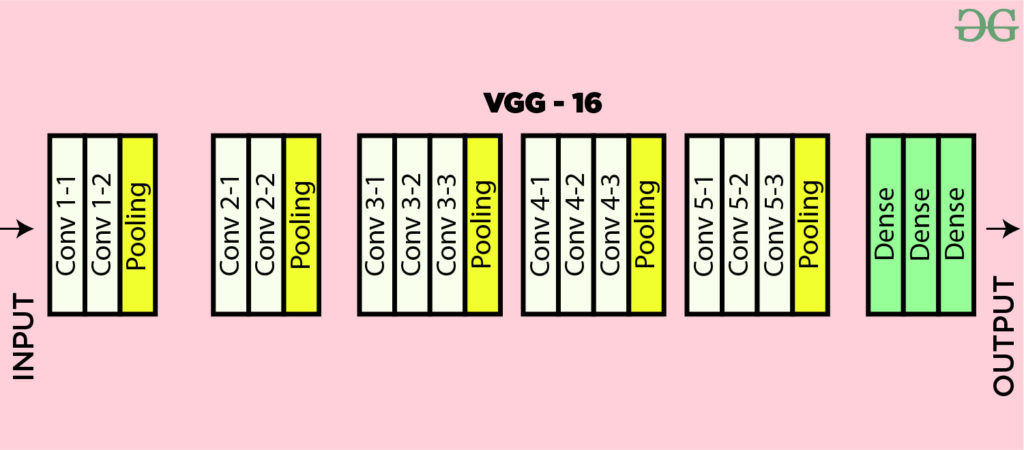

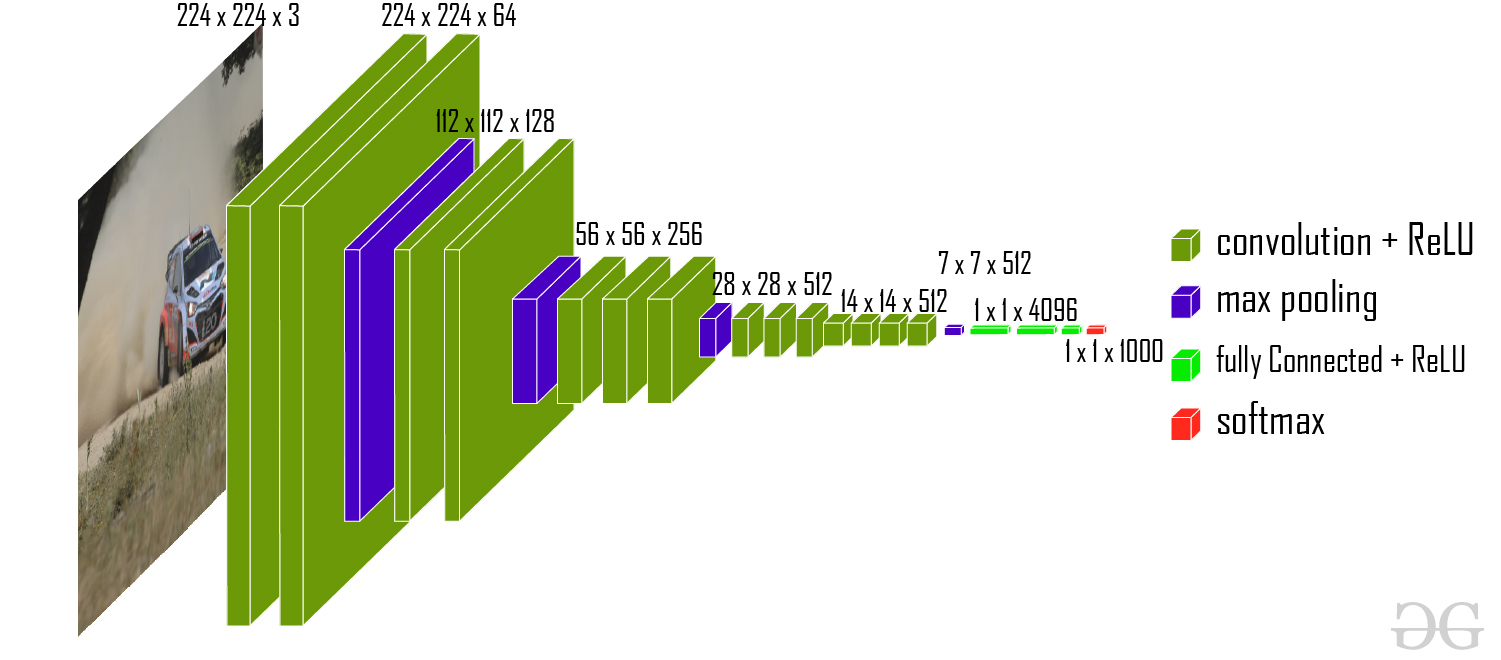

Images source: [GeeksForGeeks](https://www.geeksforgeeks.org/vgg-16-cnn-model/)

In [12]:
from src.custom_layers import  get_conv_layer, get_fc_layer

In [13]:
class VGG16(nn.Module):
    def __init__(self, num_classes=1000):
        super(VGG16, self).__init__()
        config = [64, 64, "M", 128, 128, "M", 256, 256, 256, "M", 512, 512, 512, "M", 512, 512, 512, "M"]
        layers = OrderedDict()
        in_channels = 3
        l = 1
        m = 1
        for v in config:
            if v == "M":
                layers[f"max_pool_{m}"] = nn.MaxPool2d(kernel_size=2, stride=2)
                m += 1
            else:
                layers[f"conv_layer_{l}"] = get_conv_layer(in_channels, v, kernel_size=3, stride=1, padding=1)
                l += 1
                in_channels = v
        layers["avgpool"] = nn.AdaptiveAvgPool2d(output_size=(7, 7))
        layers["flatten"] = nn.Flatten()
        layers["classifier"] = nn.Sequential(
            OrderedDict(
                [
                    ("fc1", get_fc_layer(7*7*512, 4096, dropout=0.5)),
                    ("fc2", get_fc_layer(4096, 4096, dropout=0.5)),
                    ("fc3", nn.Sequential(OrderedDict([("linear", nn.Linear(4096, num_classes))]))),
                ]
            )
        )

        self.model = nn.Sequential(layers)
        
    def forward(self, x):
        return self.model(x)

### Examining the Network Architecture

In [14]:
# Get a batch of data
X, y = next(iter(data_loaders["train"]))

In [15]:
my_vgg16 = VGG16()

In [16]:
my_vgg16

VGG16(
  (model): Sequential(
    (conv_layer_1): Sequential(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv_layer_2): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_layer_3): Sequential(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv_layer_4): Sequential(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm): BatchNorm2d(128, eps=1e-0

### Examining the Output of Every Layer

In [25]:
layers_lst = list()
def get_children(layer, level=0):
    global layers_lst
    named_children = list(layer.named_children())
    for name, child in named_children:
        is_leaf_node = len(list(child.named_children())) == 0
        layers_lst.append({"name": name, "layer": child, "level": level, "is_leaf_node": is_leaf_node})
        get_children(child, level+1)

In [26]:
get_children(my_vgg16.model)

In [28]:
X.shape

torch.Size([4, 3, 224, 224])

In [29]:
out = X
for layer in layers_lst:
    print_message = layer["level"] * "\t" + "{0:15s}".format("(" + layer["name"]+ "),")
    if layer["is_leaf_node"]:
        out = layer["layer"](out)
        print_message += f", Output shape: {list(out.shape)}"
    print(print_message)

(conv_layer_1),
	(conv),        , Output shape: [4, 64, 224, 224]
	(batch_norm),  , Output shape: [4, 64, 224, 224]
	(relu),        , Output shape: [4, 64, 224, 224]
(conv_layer_2),
	(conv),        , Output shape: [4, 64, 224, 224]
	(batch_norm),  , Output shape: [4, 64, 224, 224]
	(relu),        , Output shape: [4, 64, 224, 224]
(max_pool_1),  , Output shape: [4, 64, 112, 112]
(conv_layer_3),
	(conv),        , Output shape: [4, 128, 112, 112]
	(batch_norm),  , Output shape: [4, 128, 112, 112]
	(relu),        , Output shape: [4, 128, 112, 112]
(conv_layer_4),
	(conv),        , Output shape: [4, 128, 112, 112]
	(batch_norm),  , Output shape: [4, 128, 112, 112]
	(relu),        , Output shape: [4, 128, 112, 112]
(max_pool_2),  , Output shape: [4, 128, 56, 56]
(conv_layer_5),
	(conv),        , Output shape: [4, 256, 56, 56]
	(batch_norm),  , Output shape: [4, 256, 56, 56]
	(relu),        , Output shape: [4, 256, 56, 56]
(conv_layer_6),
	(conv),        , Output shape: [4, 256, 56, 56]
	(bat

### Model Complexity

In [30]:
# Model complexity - calculating the total number of parameters
trainable_params = sum(p.numel() for p in my_vgg16.parameters() if p.requires_grad)
trainable_params

138365992

### Visualizing the Network Using Netron

You can visualize the architecture using netron.app. Execute following cell to create `vgg16_network.pt` file. Then, go to [Netron.app](https://netron.app/) and click on Open Model, and select the file that was generated.

In [23]:
X.shape

torch.Size([4, 3, 224, 224])

In [24]:
scripted = torch.jit.trace(my_vgg16, X)

/home/fady/anaconda3/envs/fady/lib/python3.11/site-packages/torch/jit/_trace.py:1116: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 4000 / 4000 (100.0%)
Greatest absolute difference: 1.0351131856441498 at index (0, 660) (up to 1e-05 allowed)
Greatest relative difference: 2376.917672960171 at index (1, 117) (up to 1e-05 allowed)
  _check_trace(


In [25]:
torch.jit.save(scripted, "visualization/vgg16_custom_implementation.pt")

### Visualize The Computation Graph

In [26]:
from torchviz import make_dot

In [27]:
criterion = nn.CrossEntropyLoss()

In [28]:
A = my_vgg16(X)

In [29]:
loss = criterion(A, y)

In [30]:
make_dot(
    loss, 
    params=dict(list(my_vgg16.named_parameters())), 
    show_attrs=True, 
    show_saved=True
).render("visualization/vgg16_custom_implementation", format="svg")

'visualization/vgg16_custom_implementation.svg'

## Copying Pre-trained Parameters from PyTorch Model to My Custom Model

In [17]:
my_params = list(my_vgg16.parameters())
pt_params = list(vgg16_pt.parameters())

In [18]:
len(my_params)

58

In [19]:
len(pt_params)

58

In [20]:
with torch.no_grad():
    for my_param, pt_param in zip(my_vgg16.parameters(), vgg16_pt.parameters()):
        my_param.copy_(pt_param)

In [32]:
for my_param, pt_param in zip(my_vgg16.parameters(), vgg16_pt.parameters()):
    print(torch.equal(my_param, pt_param), end=" ")

True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True 

## Training on CIFAR100 Dataset

In [22]:
num_classes = 100
num_epochs = 10
batch_size = 128
learning_rate =  0.005

model_save_path = "checkpoints/best_vgg16_model.pt"

In [23]:
from src.data import get_data_loaders

In [24]:
gpu_kwargs = {
    "persistent_workers": True, 
    "pin_memory": True, 
    "pin_memory_device": 'cuda:0', 
    "prefetch_factor": 4
}

data_loaders = get_data_loaders(
                                data_dir="./data", 
                                batch_size=batch_size, 
                                dataset="CIFAR100",
                                subset_fraction=1, # Modify this value to include fractions of the dataset. Setting it to 1 will use the whole dataset.
                                num_workers=multiprocessing.cpu_count(), 
                                **gpu_kwargs
                               )

Files already downloaded and verified
Files already downloaded and verified


In [31]:
if os.path.exists(model_save_path):
    my_vgg16.load_state_dict(torch.load(model_save_path))

Using the pre-trained weights for transfer learning

In [25]:
# Transfer Learning
# Freeze the parameters of the feature extractor part of the network
for p in my_vgg16.parameters():
    p.requires_grad = False

for p in my_vgg16.model.classifier.parameters():
    p.requires_grad = True
    
# Replace the classifier 
num_features = my_vgg16.model.classifier.fc3.linear.in_features
my_vgg16.model.classifier.fc3 = nn.Linear(num_features, num_classes)
#num_ftrs  = my_vgg16.model.fc.in_features

#my_vgg16.model.fc  = nn.Linear(num_ftrs, num_classes)


In [26]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(my_vgg16.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

In [27]:
common_transforms = [
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
]

# # Other data augmentation to try for the training dataset
# train_transforms = [
#                 transforms.RandomAffine(scale=(0.9, 1.1), translate=(0.1, 0.1), degrees=10, fill=0, interpolation=transforms.InterpolationMode.BILINEAR),
#                 transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
#                 transforms.RandomHorizontalFlip(0.5),
#             ]

In [28]:
transformations = {
    "train": common_transforms, # + train_transforms
    "valid": common_transforms,
    "test": common_transforms
}

In [29]:
from src.train import training_loop

In [30]:
my_vgg16 = my_vgg16.to(device)

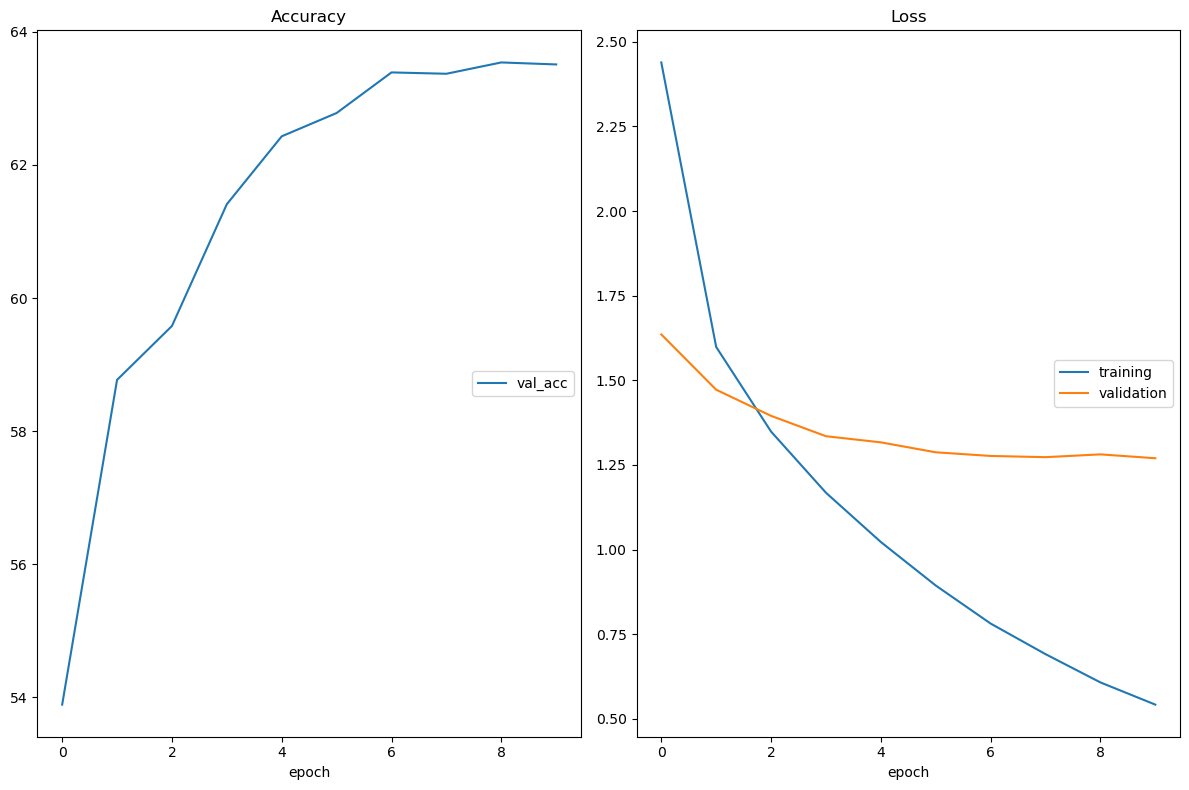

Epoch [10/10], Training Loss: 0.5419, Validation Loss: 1.2698, Validation Accuracy: 63.51%


In [31]:
training_loop(my_vgg16, device, data_loaders, optimizer, criterion, num_epochs, model_save_path, transformations)

## Testing Your Model

In [32]:
from src.train import test_one_epoch

In [33]:
# Load best weights
if os.path.exists(model_save_path):
    my_vgg16.load_state_dict(torch.load(model_save_path))
    
test_loss, test_accuracy = test_one_epoch(
    my_vgg16, 
    device, data_loaders["test"], 
    optimizer, 
    criterion, 
    description="Testing", 
    transformations=transforms.Compose(common_transforms)
)

Testing: 100%|██████████████████████████████████| 79/79 [00:57<00:00,  1.38it/s]


In [34]:
print ('Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss, 100 * test_accuracy))

Test Loss: 1.2876, Test Accuracy: 63.20%
